Task 1 a and b

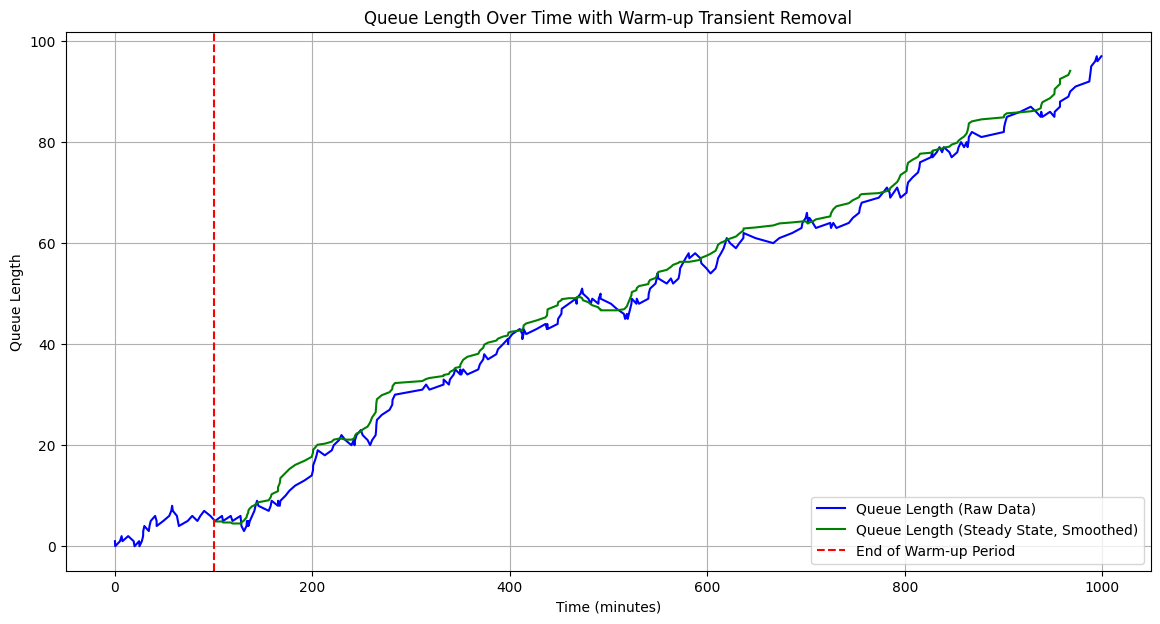

MEASUREMENTS 

No. of users in the queue: 97 
No. of arrivals = 189 - No. of departures = 92
Load:  2.0

Arrival rate:  0.189  - Departure rate:  0.092

Average number of users:  45.768366991859935
Average delay:  214.5665834944061
Actual queue size:  97
Arrival time of the last element in the queue: 998.9887062788895


In [1]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

# ******************************************************************************
# To take the measurements
# ******************************************************************************
class Measure:
    def __init__(self, Narr, Ndep, NAveraegUser, OldTimeEvent, AverageDelay, QueueLengths, TimeStamps):
        self.arr = Narr
        self.dep = Ndep
        self.ut = NAveraegUser
        self.oldT = OldTimeEvent
        self.delay = AverageDelay
        self.queue_lengths = QueueLengths
        self.time_stamps = TimeStamps

# ******************************************************************************
# Client
# ******************************************************************************
class Client:
    def __init__(self, Type, ArrivalT):
        self.type = Type
        self.Tarr = ArrivalT

# ******************************************************************************
# Constants
# ******************************************************************************
SERVICE = 10.0  # SERVICE is the average service time; service rate = 1/SERVICE
ARRIVAL = 5.0   # ARRIVAL is the average inter-arrival time; arrival rate = 1/ARRIVAL
LOAD = SERVICE / ARRIVAL  # This relationship holds for M/M/1

TYPE1 = 1
SIM_TIME = 1000  # Total simulation time

arrivals = 0
users = 0
BusyServer = False  # True: server is currently busy; False: server is currently idle

MM1 = []

# ******************************************************************************
# generator yield events to the simulator
# ******************************************************************************
def arrival_process(environment, queue):
    global users
    global BusyServer
    while True:
        # Cumulate statistics
        data.arr += 1
        data.ut += users * (environment.now - data.oldT)
        data.oldT = environment.now

        # Sample the time until the next event
        inter_arrival = random.expovariate(1.0 / ARRIVAL)

        # Update state variable and put the client in the queue
        users += 1
        cl = Client(TYPE1, environment.now)
        queue.append(cl)

        if users == 1:
            BusyServer = True
            service_time = random.expovariate(1.0 / SERVICE)
            env.process(departure_process(env, service_time, queue))

        # Log queue length and time
        data.queue_lengths.append(users)
        data.time_stamps.append(environment.now)

        # Yield an event to the simulator
        yield environment.timeout(inter_arrival)

# ******************************************************************************
# departures *******************************************************************
def departure_process(environment, service_time, queue):
    global users
    global BusyServer

    yield environment.timeout(service_time)

    # Cumulate statistics
    data.dep += 1
    data.ut += users * (environment.now - data.oldT)
    data.oldT = environment.now

    # Update state variable and extract the client in the queue
    users -= 1
    user = queue.pop(0)
    data.delay += (environment.now - user.Tarr)

    if users == 0:
        BusyServer = False
    else:
        service_time = random.expovariate(1.0 / SERVICE)
        env.process(departure_process(env, service_time, queue))

    # Log queue length and time
    data.queue_lengths.append(users)
    data.time_stamps.append(environment.now)

# ******************************************************************************
# the main body of the simulation
# ******************************************************************************
random.seed(42)
data = Measure(0, 0, 0, 0, 0, [], [])
env = simpy.Environment()
env.process(arrival_process(env, MM1))
env.run(until=SIM_TIME)

# Moving average smoothing function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plotting the results
plt.figure(figsize=(14, 7))

# Plotting the raw simulation data
plt.plot(data.time_stamps, data.queue_lengths, label='Queue Length (Raw Data)', color='blue')

# Identifying and removing warm-up transient
warm_up_period = 100  # Adjust as needed based on initial analysis
steady_state_times = [time for time in data.time_stamps if time > warm_up_period]
steady_state_queues = data.queue_lengths[len(data.time_stamps) - len(steady_state_times):]

# Apply moving average to steady state data
window_size = 10  # Adjust window size as needed
smoothed_queues = moving_average(steady_state_queues, window_size)
smoothed_times = steady_state_times[:len(smoothed_queues)]

# Plotting the smoothed data after removing warm-up transient
plt.plot(smoothed_times, smoothed_queues, label='Queue Length (Steady State, Smoothed)', color='green')

# Highlighting warm-up period
plt.axvline(x=warm_up_period, color='red', linestyle='--', label='End of Warm-up Period')

# Adding labels and legend
plt.xlabel('Time (minutes)')
plt.ylabel('Queue Length')
plt.title('Queue Length Over Time with Warm-up Transient Removal')
plt.legend()
plt.grid(True)
plt.show()

# Print output data
print("MEASUREMENTS \n\nNo. of users in the queue:", users, "\nNo. of arrivals =", data.arr, "- No. of departures =", data.dep)
print("Load: ", SERVICE / ARRIVAL)
print("\nArrival rate: ", data.arr / env.now, " - Departure rate: ", data.dep / env.now)
print("\nAverage number of users: ", data.ut / env.now)
print("Average delay: ", data.delay / data.dep)
print("Actual queue size: ", len(MM1))
if len(MM1) > 0:
    print("Arrival time of the last element in the queue:", MM1[len(MM1) - 1].Tarr)


Task 2 (a) and (b)

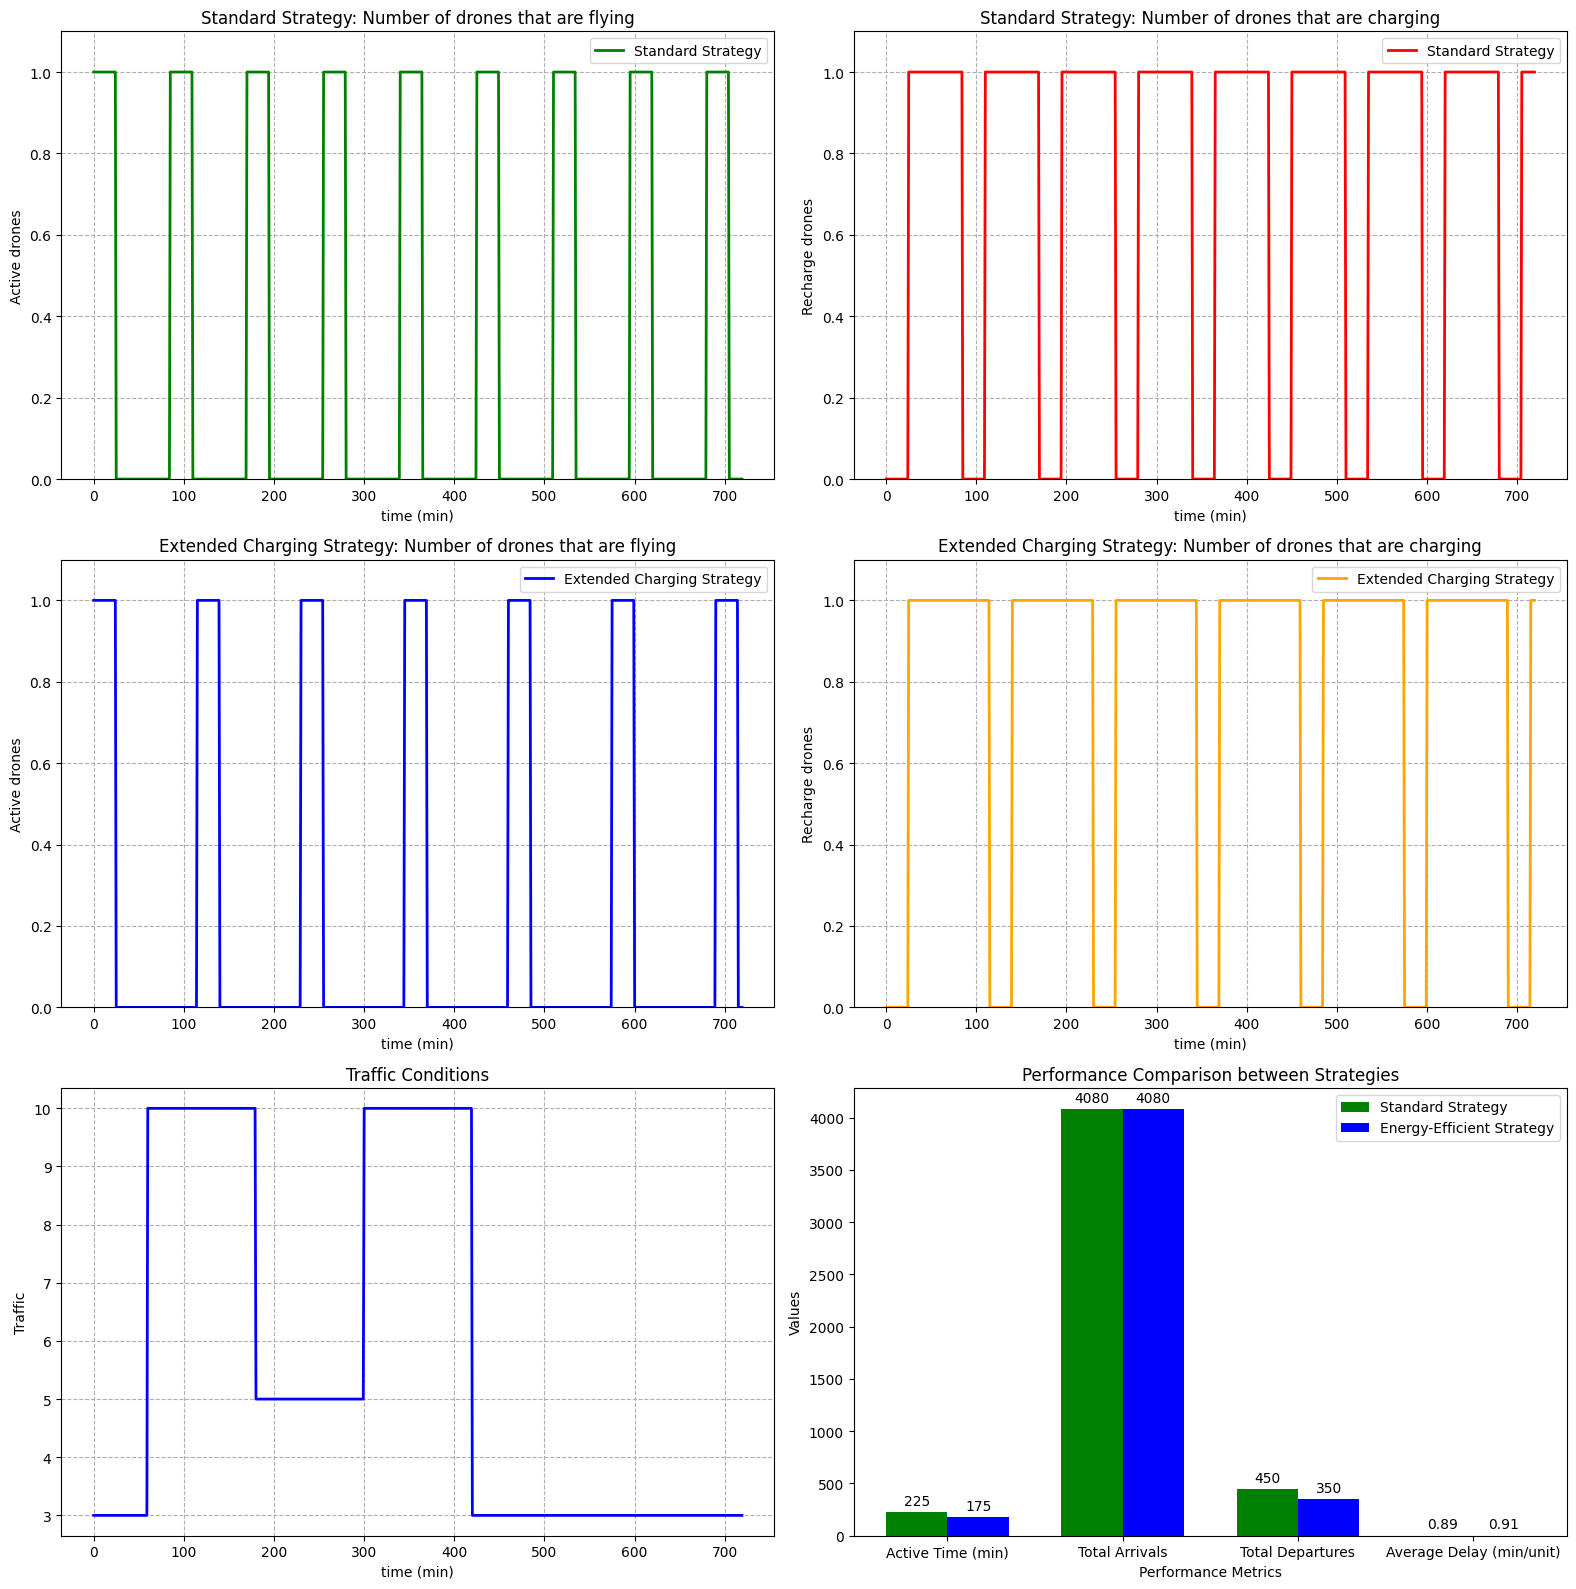

Standard Strategy:
Active Time: 225 minutes
Total Arrivals: 4080.0 units
Total Departures: 450 units
Average Delay: 0.89 minutes/unit

Energy-Efficient Strategy:
Active Time: 175 minutes
Total Arrivals: 4080.0 units
Total Departures: 350 units
Average Delay: 0.91 minutes/unit


In [2]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

# Constants for both strategies
workingtime = 25  # in minutes
standard_chargingtime = 60  # in minutes for standard strategy
efficient_chargingtime = 90  # in minutes for energy-efficient strategy
total_simulation_time = 720  # in minutes (12 hours from 8:00 AM to 8:00 PM)

# Traffic conditions with peak and off-peak hours
traffic_conditions = [
    (0, 3),    # Off-Peak (8:00 AM - 7:59 AM)
    (60, 10),  # Morning Peak (8:00 AM - 10:59 AM)
    (180, 5),  # Midday Off-Peak (11:00 AM - 12:59 PM)
    (300, 10),  # Afternoon Peak (1:00 PM - 2:59 PM)
    (420, 3)   # Evening Off-Peak (3:00 PM - 8:00 PM)
]

# Function to get traffic at a specific time
def get_traffic(time, traffic_conditions):
    for condition in traffic_conditions:
        if time >= condition[0]:
            current_traffic = condition[1]
    return current_traffic

# Function to simulate drone operation with traffic conditions
def simulate_drone_operation(chargingtime, traffic_conditions):
    time = np.arange(0, total_simulation_time, 1)
    active_drones = np.zeros(total_simulation_time)
    charging_drones = np.zeros(total_simulation_time)
    traffic_array = np.zeros(total_simulation_time)
    active_time = 0
    total_arrivals = 0
    total_departures = 0

    for t in range(total_simulation_time):
        cycle_time = (workingtime + chargingtime)
        if (t % cycle_time) < workingtime:
            active_drones[t] = 1
            charging_drones[t] = 0
            active_time += 1
        else:
            active_drones[t] = 0
            charging_drones[t] = 1
        traffic_array[t] = get_traffic(t, traffic_conditions)
        total_arrivals += traffic_array[t]
        if active_drones[t] == 1:
            total_departures += min(traffic_array[t], 2)  # assuming 2 units can be served per minute

    average_delay = (total_arrivals - total_departures) / total_arrivals if total_arrivals > 0 else 0

    return time, active_drones, charging_drones, traffic_array, active_time, total_arrivals, total_departures, average_delay

# Simulate both strategies
time, active_drones_standard, charging_drones_standard, traffic_standard, active_time_standard, total_arrivals_standard, total_departures_standard, average_delay_standard = simulate_drone_operation(standard_chargingtime, traffic_conditions)
_, active_drones_efficient, charging_drones_efficient, traffic_efficient, active_time_efficient, total_arrivals_efficient, total_departures_efficient, average_delay_efficient = simulate_drone_operation(efficient_chargingtime, traffic_conditions)

# Plot the results for both strategies
plt.figure(figsize=(16, 16))

# Standard Strategy
plt.subplot(3, 2, 1)
plt.plot(time, active_drones_standard, color='green', linestyle='-', linewidth=2, label='Standard Strategy')
plt.xlabel('time (min)')
plt.ylabel('Active drones')
plt.title('Standard Strategy: Number of drones that are flying')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(time, charging_drones_standard, color='red', linestyle='-', linewidth=2, label='Standard Strategy')
plt.xlabel('time (min)')
plt.ylabel('Recharge drones')
plt.title('Standard Strategy: Number of drones that are charging')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--')
plt.legend()

# Extended Charging Strategy
plt.subplot(3, 2, 3)
plt.plot(time, active_drones_efficient, color='blue', linestyle='-', linewidth=2, label='Extended Charging Strategy')
plt.xlabel('time (min)')
plt.ylabel('Active drones')
plt.title('Extended Charging Strategy: Number of drones that are flying')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(time, charging_drones_efficient, color='orange', linestyle='-', linewidth=2, label='Extended Charging Strategy')
plt.xlabel('time (min)')
plt.ylabel('Recharge drones')
plt.title('Extended Charging Strategy: Number of drones that are charging')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--')
plt.legend()

# Traffic Conditions
plt.subplot(3, 2, 5)
plt.plot(time, traffic_standard, color='blue', linestyle='-', linewidth=2)
plt.xlabel('time (min)')
plt.ylabel('Traffic')
plt.title('Traffic Conditions')
plt.grid(True, linestyle='--')

# Bar chart for performance comparison
metrics = ['Active Time (min)', 'Total Arrivals', 'Total Departures', 'Average Delay (min/unit)']
standard_strategy = [active_time_standard, total_arrivals_standard, total_departures_standard, average_delay_standard]
efficient_strategy = [active_time_efficient, total_arrivals_efficient, total_departures_efficient, average_delay_efficient]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(3, 2, 6)
bars1 = plt.bar(x - width/2, standard_strategy, width, label='Standard Strategy', color='green')
bars2 = plt.bar(x + width/2, efficient_strategy, width, label='Energy-Efficient Strategy', color='blue')

for bar in bars1:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Performance Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison between Strategies')
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison metrics
print("Standard Strategy:")
print(f"Active Time: {active_time_standard} minutes")
print(f"Total Arrivals: {total_arrivals_standard} units")
print(f"Total Departures: {total_departures_standard} units")
print(f"Average Delay: {average_delay_standard:.2f} minutes/unit")

print("\nEnergy-Efficient Strategy:")
print(f"Active Time: {active_time_efficient} minutes")
print(f"Total Arrivals: {total_arrivals_efficient} units")
print(f"Total Departures: {total_departures_efficient} units")
print(f"Average Delay: {average_delay_efficient:.2f} minutes/unit")


Task2 (c)

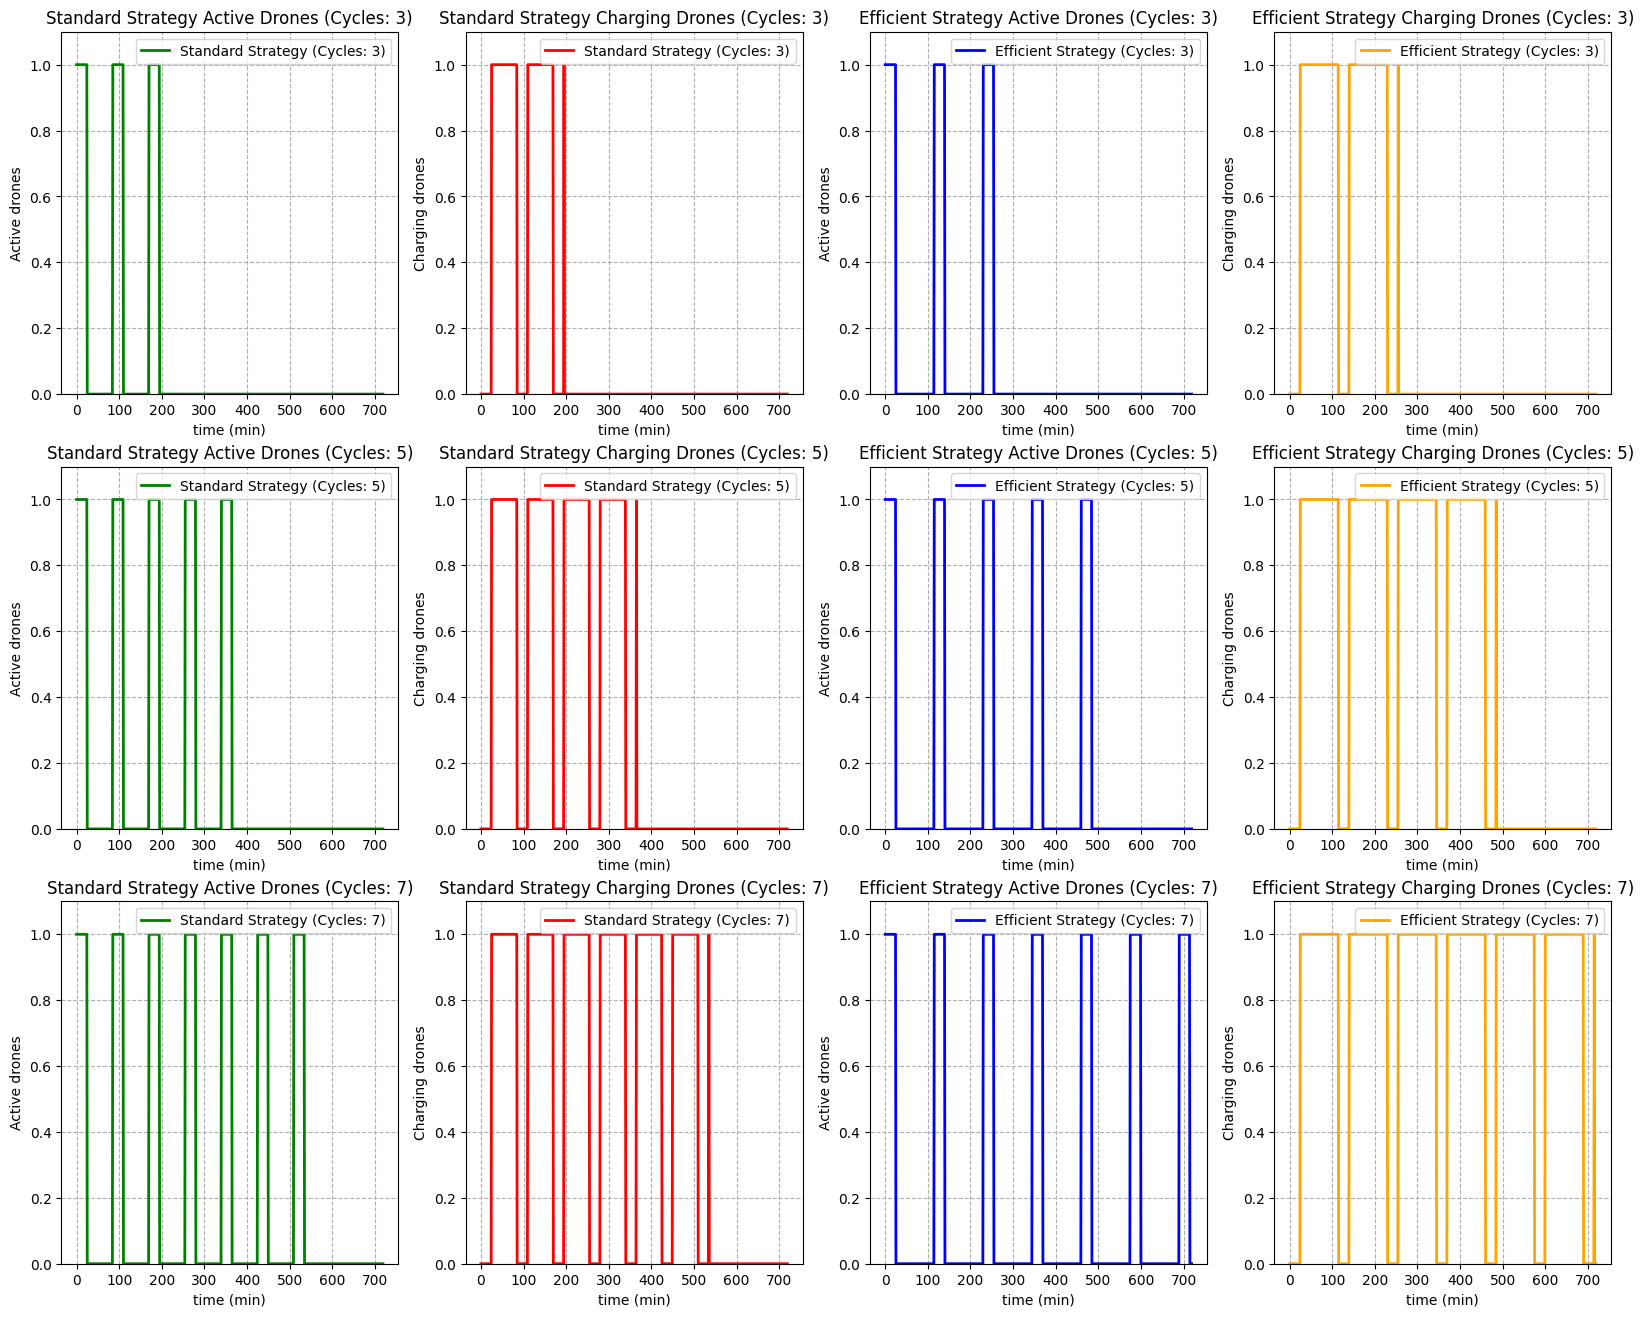

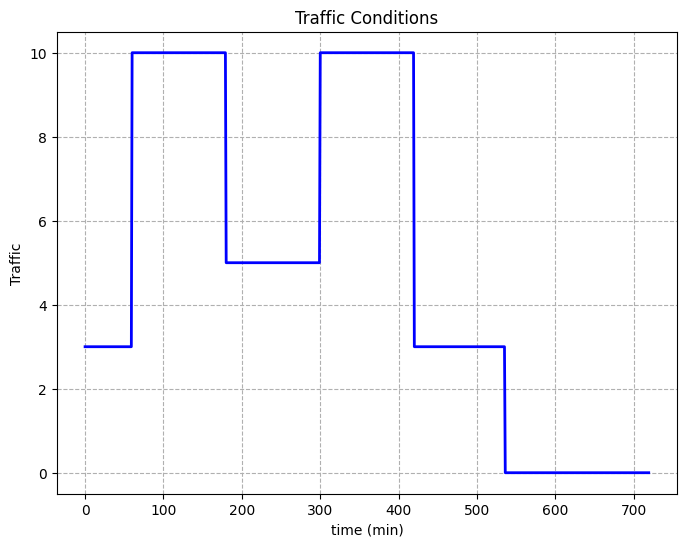

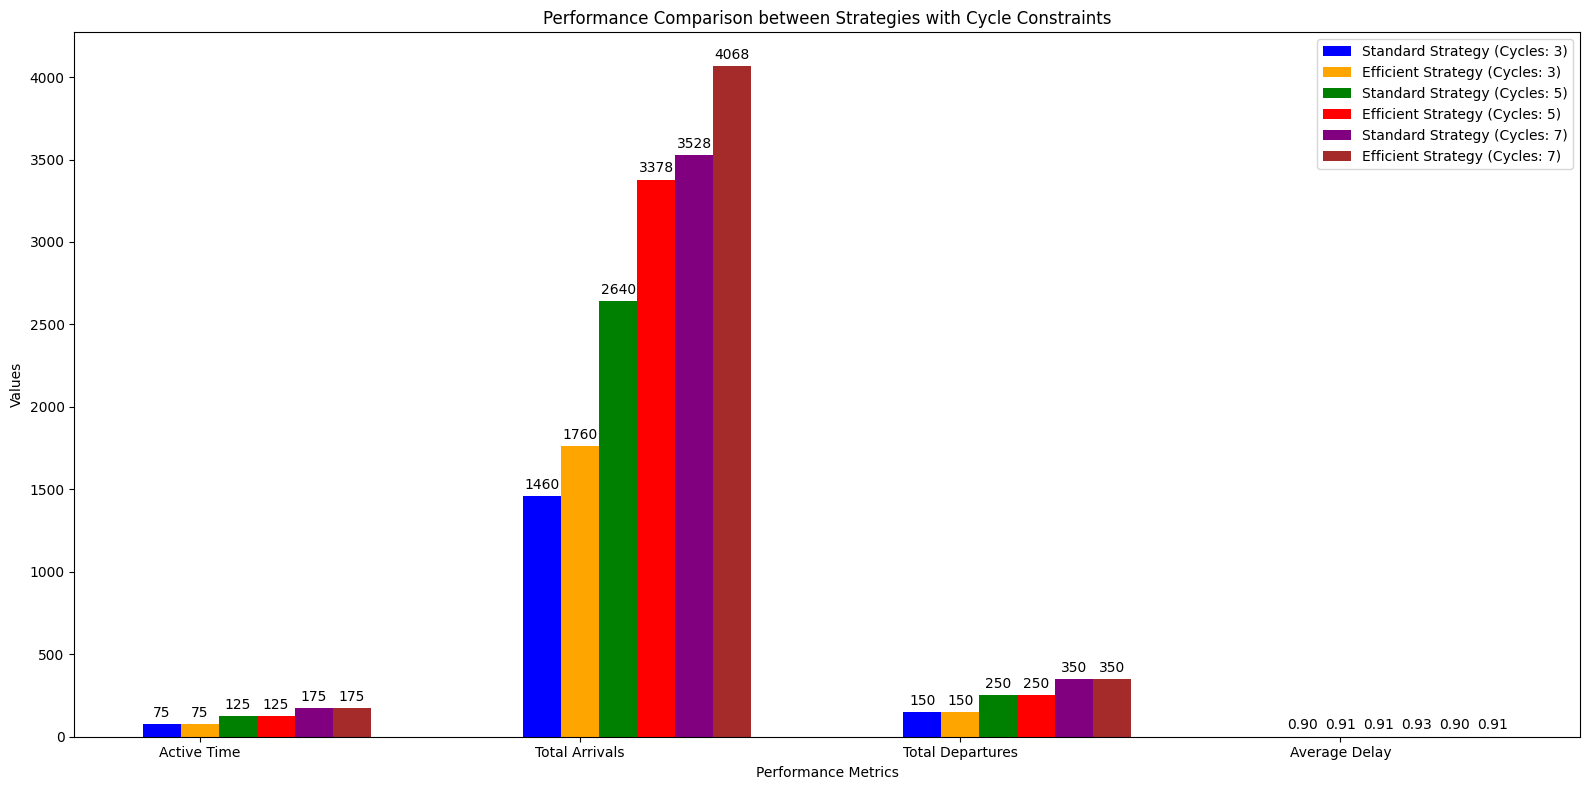


Cycle Threshold: 3
Standard Strategy:
Active Time: 75 minutes
Total Arrivals: 1460.0 units
Total Departures: 150 units
Average Delay: 0.90 minutes/unit
Cycles: 3

Energy-Efficient Strategy:
Active Time: 75 minutes
Total Arrivals: 1760.0 units
Total Departures: 150 units
Average Delay: 0.91 minutes/unit
Cycles: 3

Cycle Threshold: 5
Standard Strategy:
Active Time: 125 minutes
Total Arrivals: 2640.0 units
Total Departures: 250 units
Average Delay: 0.91 minutes/unit
Cycles: 5

Energy-Efficient Strategy:
Active Time: 125 minutes
Total Arrivals: 3378.0 units
Total Departures: 250 units
Average Delay: 0.93 minutes/unit
Cycles: 5

Cycle Threshold: 7
Standard Strategy:
Active Time: 175 minutes
Total Arrivals: 3528.0 units
Total Departures: 350 units
Average Delay: 0.90 minutes/unit
Cycles: 7

Energy-Efficient Strategy:
Active Time: 175 minutes
Total Arrivals: 4068.0 units
Total Departures: 350 units
Average Delay: 0.91 minutes/unit
Cycles: 7


In [3]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

# Constants for both strategies
workingtime = 25  # in minutes
standard_chargingtime = 60  # in minutes for standard strategy
efficient_chargingtime = 90  # in minutes for energy-efficient strategy
total_simulation_time = 720  # in minutes (12 hours from 8:00 AM to 8:00 PM)
max_cycles = 5  # Maximum number of charging cycles allowed per day

# Traffic conditions with peak and off-peak hours
traffic_conditions = [
    (0, 3),    # Off-Peak (8:00 AM - 7:59 AM)
    (60, 10),  # Morning Peak (8:00 AM - 10:59 AM)
    (180, 5),  # Midday Off-Peak (11:00 AM - 12:59 PM)
    (300, 10),  # Afternoon Peak (1:00 PM - 2:59 PM)
    (420, 3)   # Evening Off-Peak (3:00 PM - 8:00 PM)
]

# Function to get traffic at a specific time
def get_traffic(time, traffic_conditions):
    for condition in traffic_conditions:
        if time >= condition[0]:
            current_traffic = condition[1]
    return current_traffic

# Function to simulate drone operation with traffic conditions and battery cycle constraint
def simulate_drone_operation(chargingtime, traffic_conditions, max_cycles):
    time = np.arange(0, total_simulation_time, 1)
    active_drones = np.zeros(total_simulation_time)
    charging_drones = np.zeros(total_simulation_time)
    traffic_array = np.zeros(total_simulation_time)
    active_time = 0
    total_arrivals = 0
    total_departures = 0
    cycles = 0

    for t in range(total_simulation_time):
        if cycles >= max_cycles:
            break  # Stop simulation if maximum cycles are reached

        cycle_time = (workingtime + chargingtime)
        if (t % cycle_time) < workingtime:
            active_drones[t] = 1
            charging_drones[t] = 0
            active_time += 1
        else:
            active_drones[t] = 0
            charging_drones[t] = 1
            if (t % cycle_time) == workingtime:
                cycles += 1  # Increment cycle count at the start of each charging period

        traffic_array[t] = get_traffic(t, traffic_conditions)
        total_arrivals += traffic_array[t]
        if active_drones[t] == 1:
            total_departures += min(traffic_array[t], 2)  # assuming 2 units can be served per minute

    average_delay = (total_arrivals - total_departures) / total_arrivals if total_arrivals > 0 else 0

    return time, active_drones, charging_drones, traffic_array, active_time, total_arrivals, total_departures, average_delay, cycles

# Simulate both strategies with cycle constraints
max_cycles_values = [3, 5, 7]  # Different threshold values for testing
results = {}

for max_cycles in max_cycles_values:
    time, active_drones_standard, charging_drones_standard, traffic_standard, active_time_standard, total_arrivals_standard, total_departures_standard, average_delay_standard, cycles_standard = simulate_drone_operation(standard_chargingtime, traffic_conditions, max_cycles)
    _, active_drones_efficient, charging_drones_efficient, traffic_efficient, active_time_efficient, total_arrivals_efficient, total_departures_efficient, average_delay_efficient, cycles_efficient = simulate_drone_operation(efficient_chargingtime, traffic_conditions, max_cycles)
    
    results[max_cycles] = {
        "Standard": {
            "Active Time": active_time_standard,
            "Total Arrivals": total_arrivals_standard,
            "Total Departures": total_departures_standard,
            "Average Delay": average_delay_standard,
            "Cycles": cycles_standard,
            "Active Drones": active_drones_standard,
            "Charging Drones": charging_drones_standard
        },
        "Efficient": {
            "Active Time": active_time_efficient,
            "Total Arrivals": total_arrivals_efficient,
            "Total Departures": total_departures_efficient,
            "Average Delay": average_delay_efficient,
            "Cycles": cycles_efficient,
            "Active Drones": active_drones_efficient,
            "Charging Drones": charging_drones_efficient
        }
    }

# Plot the results for both strategies
fig, axes = plt.subplots(len(max_cycles_values), 4, figsize=(20, 16))

for i, max_cycles in enumerate(max_cycles_values):
    # Standard Strategy Active Drones
    axes[i, 0].plot(time, results[max_cycles]["Standard"]["Active Drones"], color='green', linestyle='-', linewidth=2, label=f'Standard Strategy (Cycles: {max_cycles})')
    axes[i, 0].set_xlabel('time (min)')
    axes[i, 0].set_ylabel('Active drones')
    axes[i, 0].set_title(f'Standard Strategy Active Drones (Cycles: {max_cycles})')
    axes[i, 0].set_ylim(0, 1.1)
    axes[i, 0].grid(True, linestyle='--')
    axes[i, 0].legend()

    # Standard Strategy Charging Drones
    axes[i, 1].plot(time, results[max_cycles]["Standard"]["Charging Drones"], color='red', linestyle='-', linewidth=2, label=f'Standard Strategy (Cycles: {max_cycles})')
    axes[i, 1].set_xlabel('time (min)')
    axes[i, 1].set_ylabel('Charging drones')
    axes[i, 1].set_title(f'Standard Strategy Charging Drones (Cycles: {max_cycles})')
    axes[i, 1].set_ylim(0, 1.1)
    axes[i, 1].grid(True, linestyle='--')
    axes[i, 1].legend()

    # Efficient Strategy Active Drones
    axes[i, 2].plot(time, results[max_cycles]["Efficient"]["Active Drones"], color='blue', linestyle='-', linewidth=2, label=f'Efficient Strategy (Cycles: {max_cycles})')
    axes[i, 2].set_xlabel('time (min)')
    axes[i, 2].set_ylabel('Active drones')
    axes[i, 2].set_title(f'Efficient Strategy Active Drones (Cycles: {max_cycles})')
    axes[i, 2].set_ylim(0, 1.1)
    axes[i, 2].grid(True, linestyle='--')
    axes[i, 2].legend()

    # Efficient Strategy Charging Drones
    axes[i, 3].plot(time, results[max_cycles]["Efficient"]["Charging Drones"], color='orange', linestyle='-', linewidth=2, label=f'Efficient Strategy (Cycles: {max_cycles})')
    axes[i, 3].set_xlabel('time (min)')
    axes[i, 3].set_ylabel('Charging drones')
    axes[i, 3].set_title(f'Efficient Strategy Charging Drones (Cycles: {max_cycles})')
    axes[i, 3].set_ylim(0, 1.1)
    axes[i, 3].grid(True, linestyle='--')
    axes[i, 3].legend()

# Traffic Conditions
fig_traffic, ax_traffic = plt.subplots(figsize=(8, 6))
ax_traffic.plot(time, traffic_standard, color='blue', linestyle='-', linewidth=2)
ax_traffic.set_xlabel('time (min)')
ax_traffic.set_ylabel('Traffic')
ax_traffic.set_title('Traffic Conditions')
ax_traffic.grid(True, linestyle='--')


# Plot the results for both strategies
fig, ax = plt.subplots(figsize=(16, 8))

# Bar chart for performance comparison for different cycle thresholds
metrics = ['Active Time', 'Total Arrivals', 'Total Departures', 'Average Delay']
x = np.arange(len(metrics))
width = 0.1  # Adjusted width

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for i, max_cycles in enumerate(max_cycles_values):
    standard_strategy = [results[max_cycles]["Standard"]["Active Time"], results[max_cycles]["Standard"]["Total Arrivals"], results[max_cycles]["Standard"]["Total Departures"], results[max_cycles]["Standard"]["Average Delay"]]
    efficient_strategy = [results[max_cycles]["Efficient"]["Active Time"], results[max_cycles]["Efficient"]["Total Arrivals"], results[max_cycles]["Efficient"]["Total Departures"], results[max_cycles]["Efficient"]["Average Delay"]]

    bars1 = ax.bar(x - width + i*width*2, standard_strategy, width, label=f'Standard Strategy (Cycles: {max_cycles})', color=colors[i*2])
    bars2 = ax.bar(x + i*width*2, efficient_strategy, width, label=f'Efficient Strategy (Cycles: {max_cycles})', color=colors[i*2+1])

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Comparison between Strategies with Cycle Constraints')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

# Print comparison metrics
for max_cycles in max_cycles_values:
    print(f"\nCycle Threshold: {max_cycles}")
    print("Standard Strategy:")
    print(f"Active Time: {results[max_cycles]['Standard']['Active Time']} minutes")
    print(f"Total Arrivals: {results[max_cycles]['Standard']['Total Arrivals']} units")
    print(f"Total Departures: {results[max_cycles]['Standard']['Total Departures']} units")
    print(f"Average Delay: {results[max_cycles]['Standard']['Average Delay']:.2f} minutes/unit")
    print(f"Cycles: {results[max_cycles]['Standard']['Cycles']}")

    print("\nEnergy-Efficient Strategy:")
    print(f"Active Time: {results[max_cycles]['Efficient']['Active Time']} minutes")
    print(f"Total Arrivals: {results[max_cycles]['Efficient']['Total Arrivals']} units")
    print(f"Total Departures: {results[max_cycles]['Efficient']['Total Departures']} units")
    print(f"Average Delay: {results[max_cycles]['Efficient']['Average Delay']:.2f} minutes/unit")
    print(f"Cycles: {results[max_cycles]['Efficient']['Cycles']}")

task3 (a)

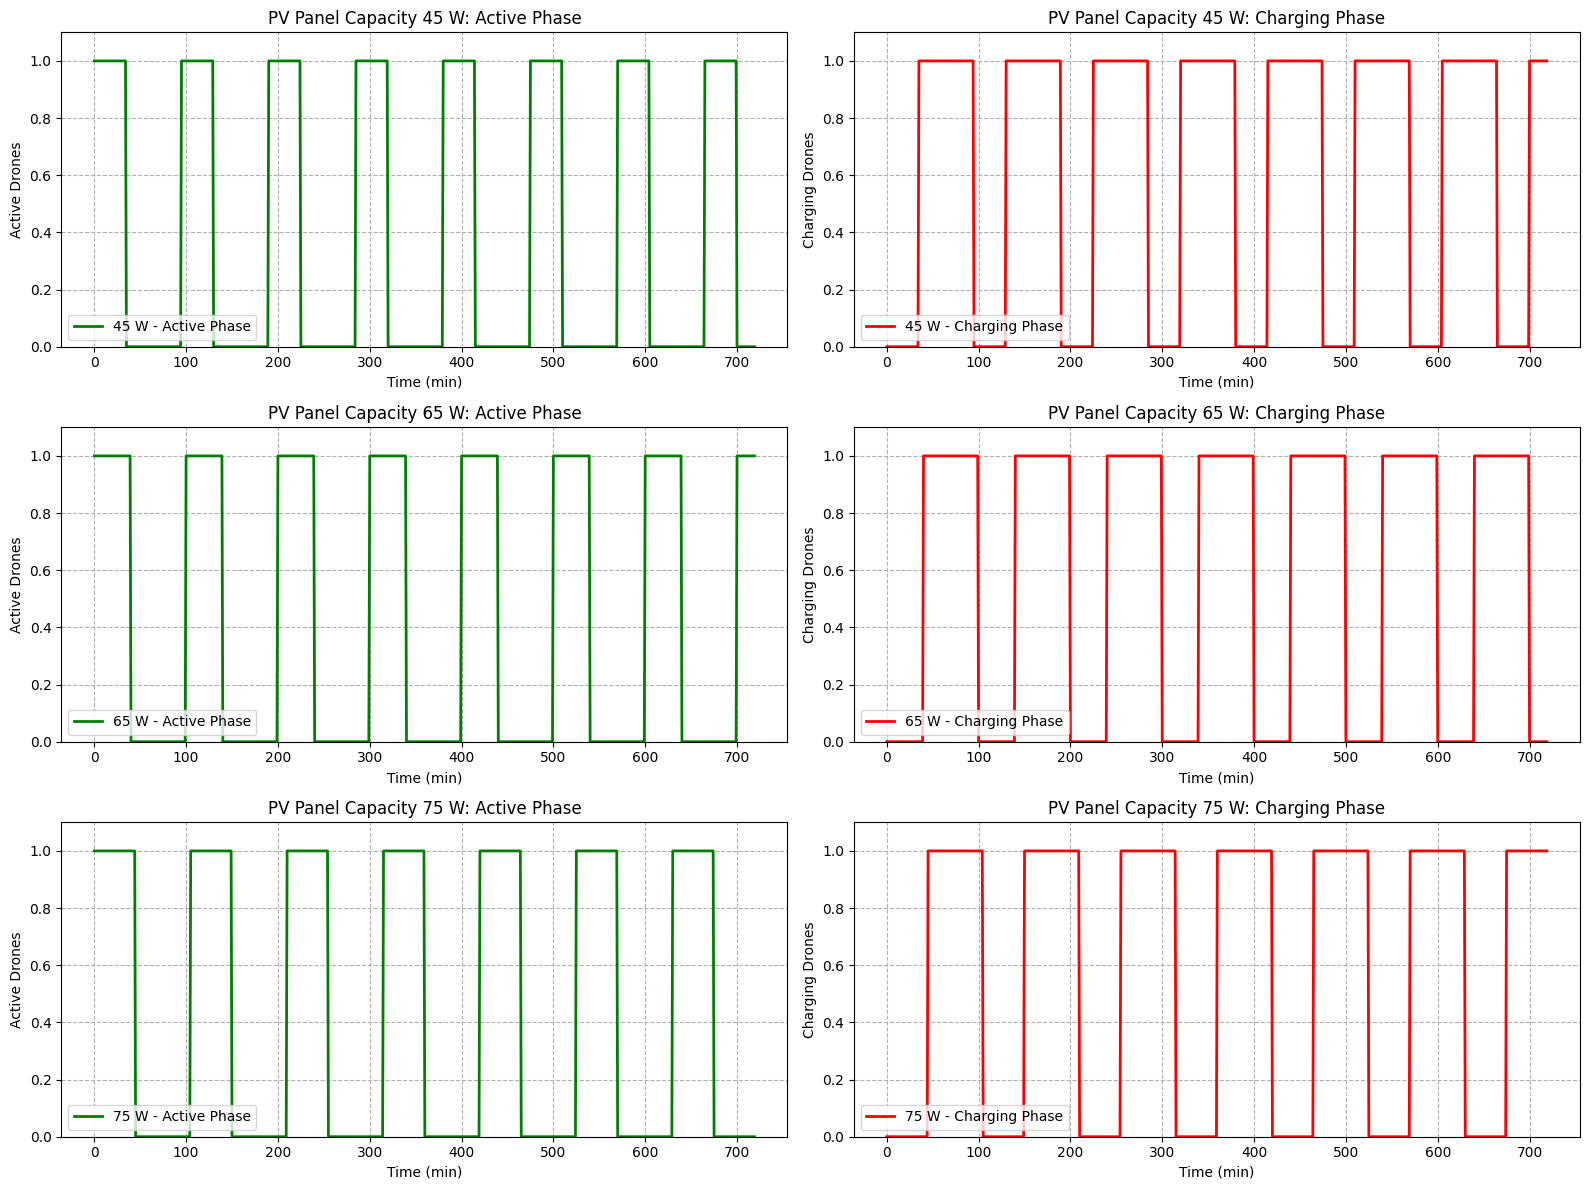

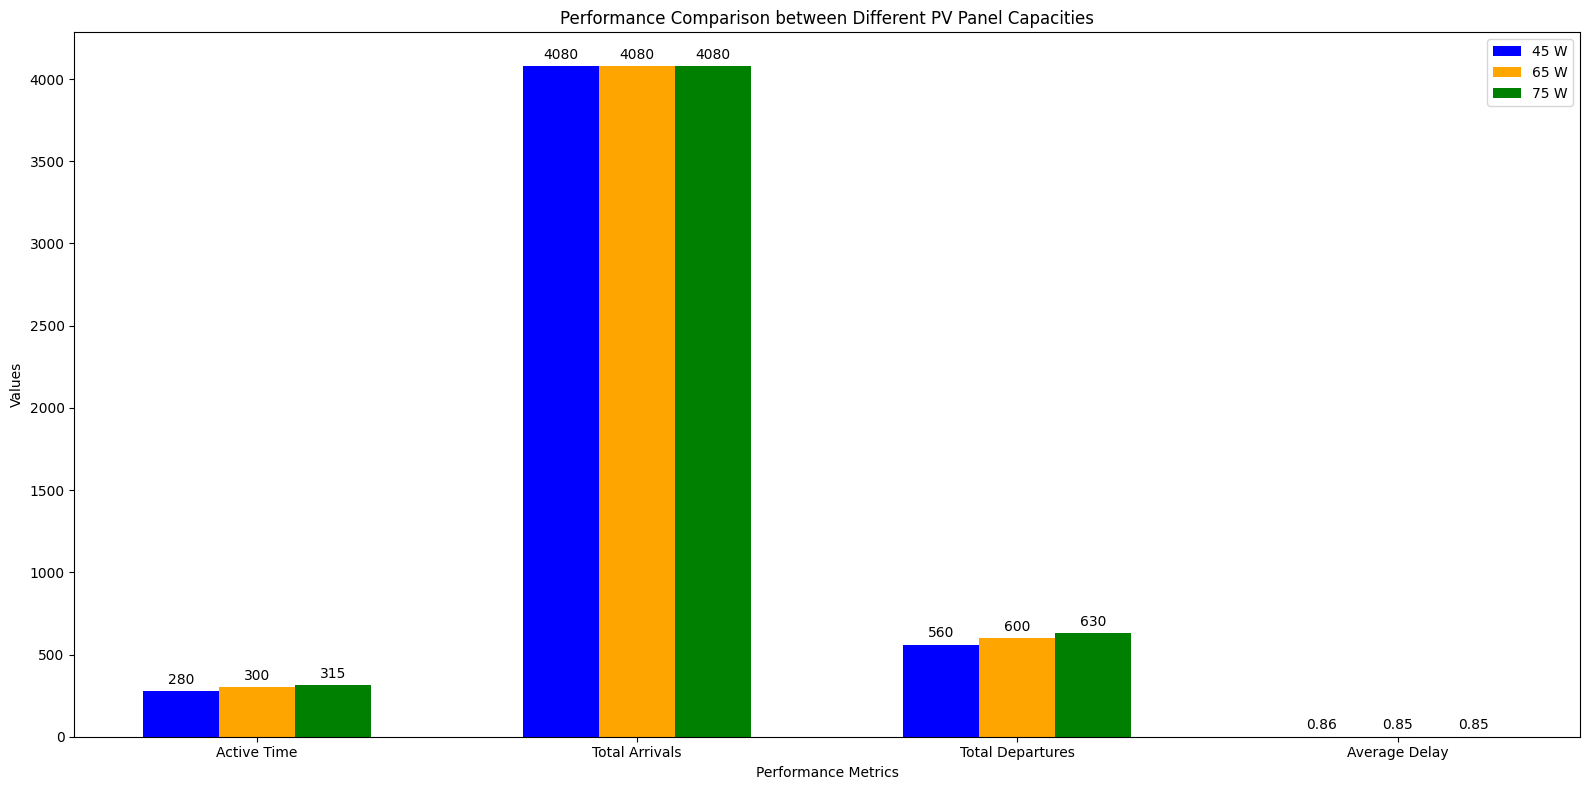


PV Panel Capacity: 45 W
Standard Strategy:
Active Time: 280 minutes
Total Arrivals: 4080.0 units
Total Departures: 560 units
Average Delay: 0.86 minutes/unit

PV Panel Capacity: 65 W
Standard Strategy:
Active Time: 300 minutes
Total Arrivals: 4080.0 units
Total Departures: 600 units
Average Delay: 0.85 minutes/unit

PV Panel Capacity: 75 W
Standard Strategy:
Active Time: 315 minutes
Total Arrivals: 4080.0 units
Total Departures: 630 units
Average Delay: 0.85 minutes/unit


In [4]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

# Constants for both strategies
standard_chargingtime = 60  # in minutes for standard strategy
total_simulation_time = 720  # in minutes (12 hours from 8:00 AM to 8:00 PM)

# PV panel capacities and corresponding drone autonomies during daytime
pv_panel_capacities = {
    45: 35,  # 45 W -> 35 minutes autonomy
    65: 40,  # 65 W -> 40 minutes autonomy
    75: 45   # 75 W -> 45 minutes autonomy
}

# Traffic conditions with peak and off-peak hours
traffic_conditions = [
    (0, 3),    # Off-Peak (8:00 AM - 7:59 AM)
    (60, 10),  # Morning Peak (8:00 AM - 10:59 AM)
    (180, 5),  # Midday Off-Peak (11:00 AM - 12:59 PM)
    (300, 10),  # Afternoon Peak (1:00 PM - 2:59 PM)
    (420, 3)   # Evening Off-Peak (3:00 PM - 8:00 PM)
]

# Function to get traffic at a specific time
def get_traffic(time, traffic_conditions):
    for condition in traffic_conditions:
        if time >= condition[0]:
            current_traffic = condition[1]
    return current_traffic

# Function to simulate drone operation with traffic conditions and PV panel capacity
def simulate_drone_operation(autonomy, traffic_conditions):
    time = np.arange(0, total_simulation_time, 1)
    active_drones = np.zeros(total_simulation_time)
    charging_drones = np.zeros(total_simulation_time)
    traffic_array = np.zeros(total_simulation_time)
    active_time = 0
    total_arrivals = 0
    total_departures = 0
    cycles = 0

    for t in range(total_simulation_time):
        if t % (autonomy + standard_chargingtime) < autonomy:
            active_drones[t] = 1
            charging_drones[t] = 0
            active_time += 1
        else:
            active_drones[t] = 0
            charging_drones[t] = 1

        traffic_array[t] = get_traffic(t, traffic_conditions)
        total_arrivals += traffic_array[t]
        if active_drones[t] == 1:
            total_departures += min(traffic_array[t], 2)  # assuming 2 units can be served per minute

    average_delay = (total_arrivals - total_departures) / total_arrivals if total_arrivals > 0 else 0

    return time, active_drones, charging_drones, traffic_array, active_time, total_arrivals, total_departures, average_delay

# Simulate the operation for each PV panel capacity
results = {}
for capacity, autonomy in pv_panel_capacities.items():
    time, active_drones, charging_drones, traffic, active_time, total_arrivals, total_departures, average_delay = simulate_drone_operation(autonomy, traffic_conditions)
    results[capacity] = {
        "Time": time,
        "Active Drones": active_drones,
        "Charging Drones": charging_drones,
        "Traffic": traffic,
        "Active Time": active_time,
        "Total Arrivals": total_arrivals,
        "Total Departures": total_departures,
        "Average Delay": average_delay
    }

# Plot the results for each PV panel capacity
fig, axes = plt.subplots(len(pv_panel_capacities), 2, figsize=(16, 12))

for i, (capacity, result) in enumerate(results.items()):
    axes[i, 0].plot(result["Time"], result["Active Drones"], color='green', linestyle='-', linewidth=2, label=f'{capacity} W - Active Phase')
    axes[i, 0].set_xlabel('Time (min)')
    axes[i, 0].set_ylabel('Active Drones')
    axes[i, 0].set_title(f'PV Panel Capacity {capacity} W: Active Phase')
    axes[i, 0].set_ylim(0, 1.1)
    axes[i, 0].grid(True, linestyle='--')
    axes[i, 0].legend()

    axes[i, 1].plot(result["Time"], result["Charging Drones"], color='red', linestyle='-', linewidth=2, label=f'{capacity} W - Charging Phase')
    axes[i, 1].set_xlabel('Time (min)')
    axes[i, 1].set_ylabel('Charging Drones')
    axes[i, 1].set_title(f'PV Panel Capacity {capacity} W: Charging Phase')
    axes[i, 1].set_ylim(0, 1.1)
    axes[i, 1].grid(True, linestyle='--')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Plot the performance comparison
fig, ax = plt.subplots(figsize=(16, 8))

# Bar chart for performance comparison for different PV panel capacities
metrics = ['Active Time', 'Total Arrivals', 'Total Departures', 'Average Delay']
x = np.arange(len(metrics))
width = 0.2  # Adjusted width

colors = ['blue', 'orange', 'green']

for i, (capacity, result) in enumerate(results.items()):
    performance = [result["Active Time"], result["Total Arrivals"], result["Total Departures"], result["Average Delay"]]
    bars = ax.bar(x + i*width, performance, width, label=f'{capacity} W', color=colors[i])

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Comparison between Different PV Panel Capacities')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

# Print comparison metrics
for capacity, result in results.items():
    print(f"\nPV Panel Capacity: {capacity} W")
    print("Standard Strategy:")
    print(f"Active Time: {result['Active Time']} minutes")
    print(f"Total Arrivals: {result['Total Arrivals']} units")
    print(f"Total Departures: {result['Total Departures']} units")
    print(f"Average Delay: {result['Average Delay']:.2f} minutes/unit")


Task 4 (a)

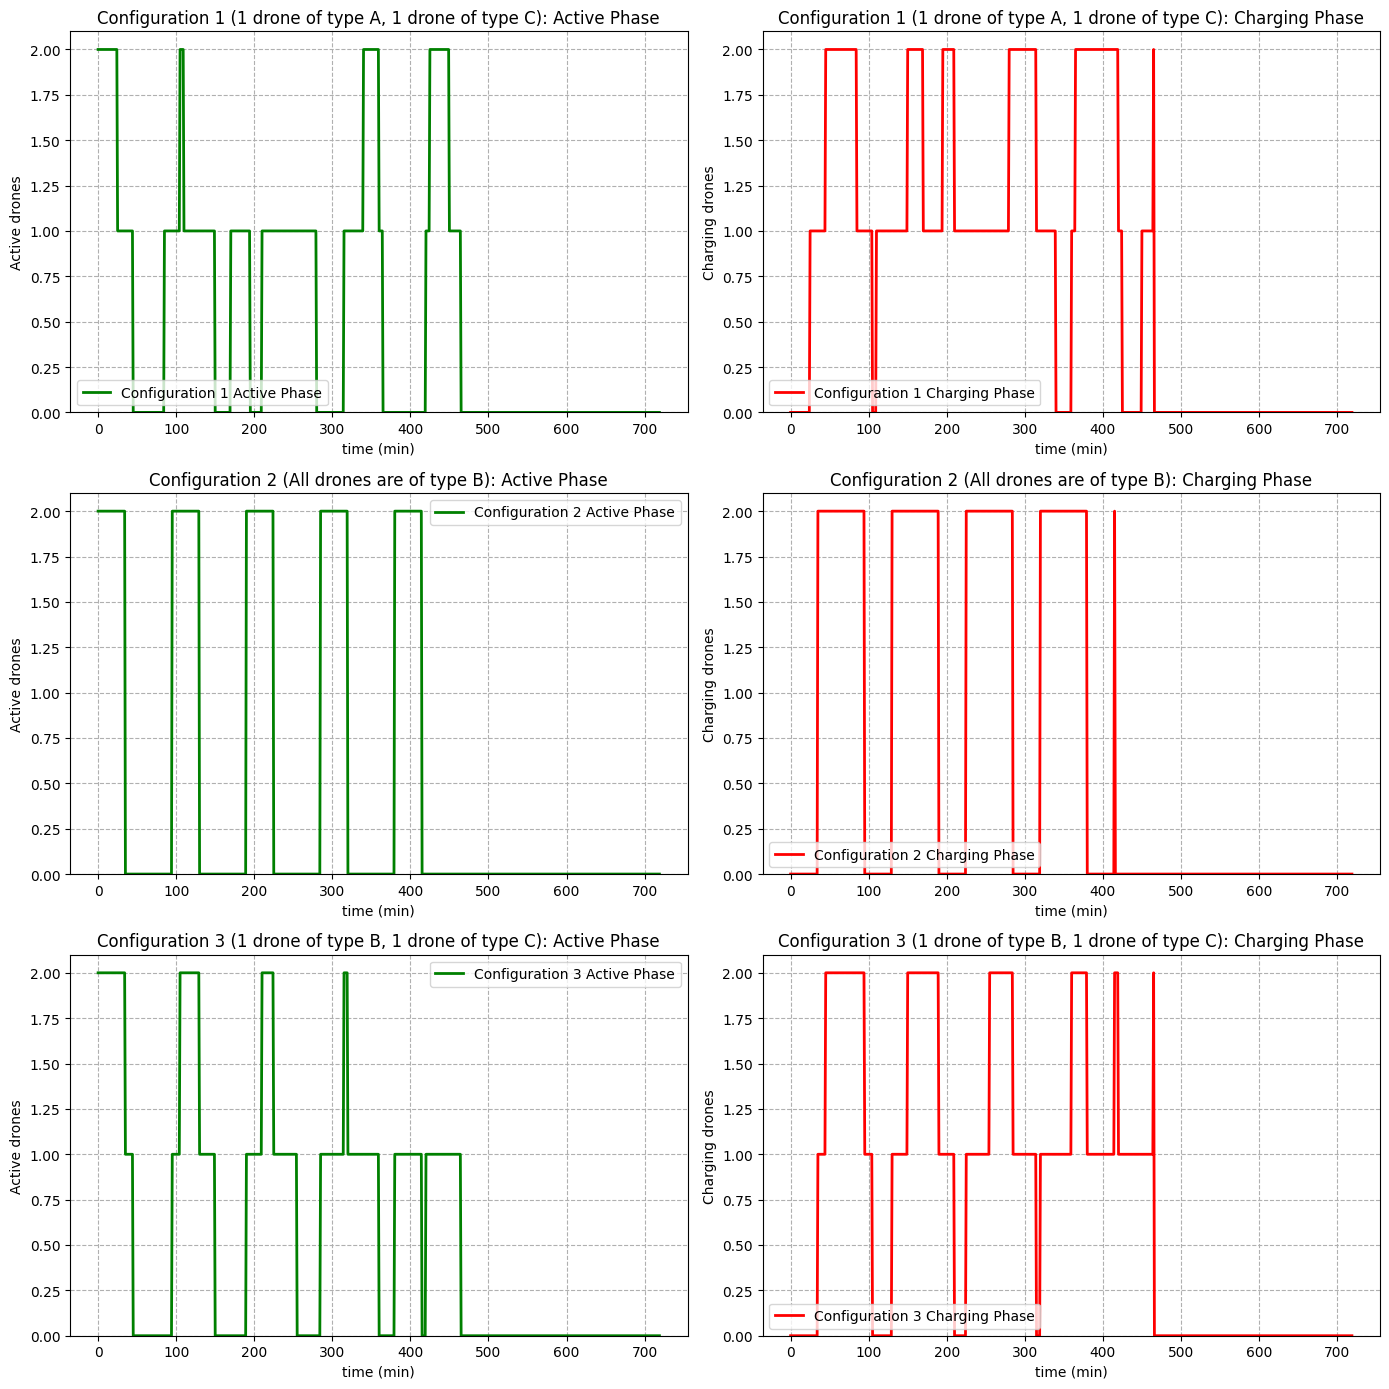

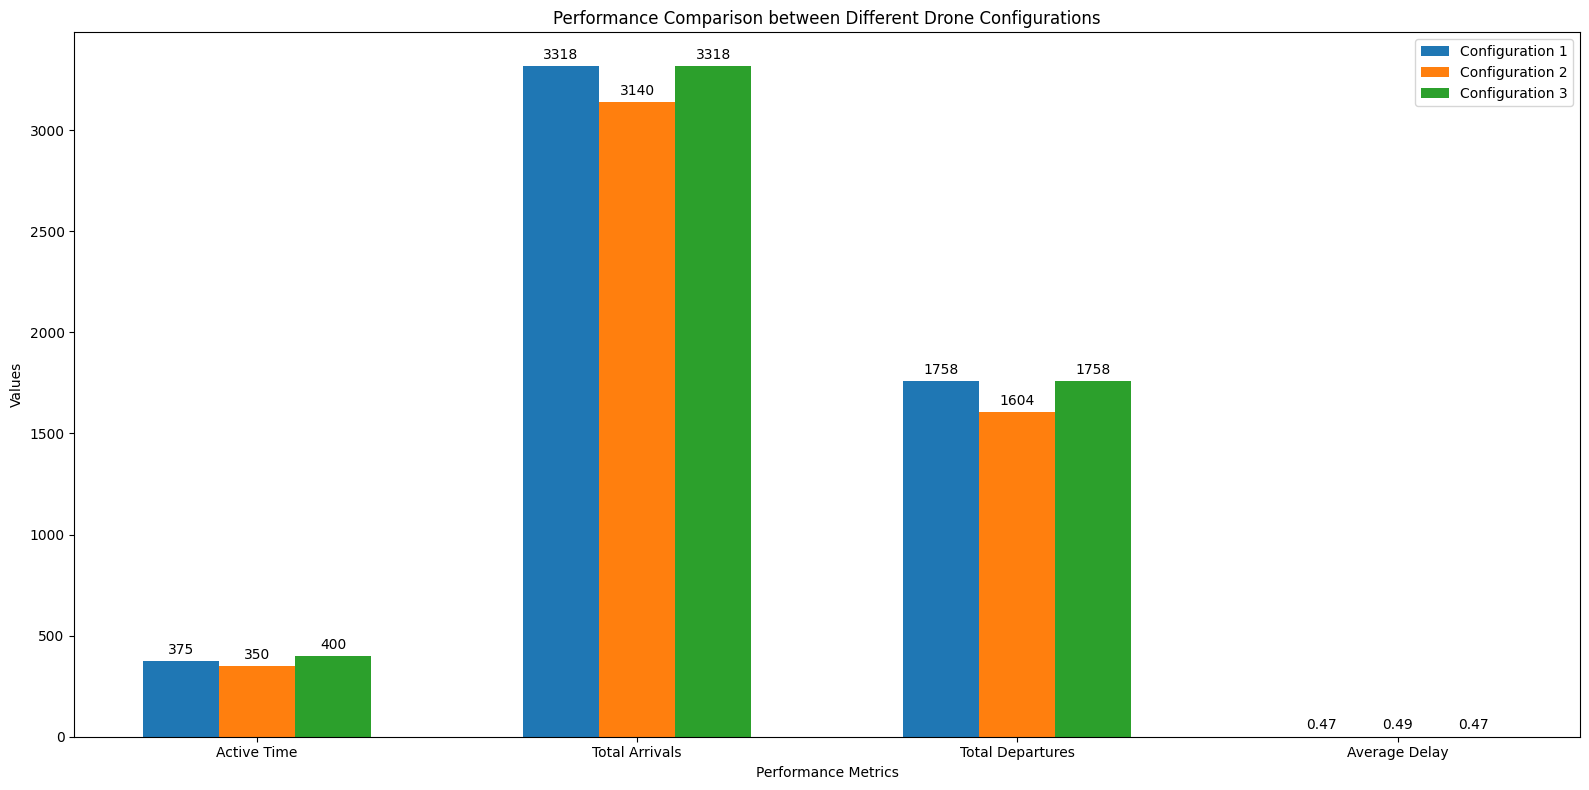


Configuration 1: 1 drone of type A, 1 drone of type C
Active Time: 375 minutes
Total Arrivals: 3318.0 units
Total Departures: 1758.0 units
Average Delay: 0.47 minutes/unit
Cycle Counts: [6. 5.]

Configuration 2: All drones are of type B
Active Time: 350 minutes
Total Arrivals: 3140.0 units
Total Departures: 1604.0 units
Average Delay: 0.49 minutes/unit
Cycle Counts: [5. 5.]

Configuration 3: 1 drone of type B, 1 drone of type C
Active Time: 400 minutes
Total Arrivals: 3318.0 units
Total Departures: 1758.0 units
Average Delay: 0.47 minutes/unit
Cycle Counts: [5. 5.]


In [5]:
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np

# Constants
workingtime_a = 25  # Active time for Type A drone
workingtime_b = 35  # Active time for Type B drone (with small PV panel)
workingtime_c = 45  # Active time for Type C drone (with larger PV panel)
chargingtime = 60   # Charging time for all drones
total_simulation_time = 720  # 12 hours from 8:00 AM to 8:00 PM
service_rate_mu = 1  # Service rate for drones
sA = 100  # Buffer size for Type A and B drones
sC = 2 * sA  # Buffer size for Type C drone

# Traffic conditions with corrected peak hours
traffic_conditions = [
    (0, 3),    # Off-Peak (8:00 AM - 7:59 AM)
    (60, 10),  # Morning Peak (8:00 AM - 10:59 AM)
    (180, 5),  # Midday Off-Peak (11:00 AM - 12:59 PM)
    (300, 10),  # Afternoon Peak (1:00 PM - 2:59 PM)
    (420, 3)   # Evening Off-Peak (3:00 PM - 8:00 PM)
]

# Function to get traffic at a specific time
def get_traffic(time, traffic_conditions):
    for condition in traffic_conditions:
        if time >= condition[0]:
            current_traffic = condition[1]
    return current_traffic

# Function to simulate drone operation with traffic conditions and battery cycle constraint
def simulate_drone_operation(types, traffic_conditions):
    time = np.arange(0, total_simulation_time, 1)
    active_drones = np.zeros(total_simulation_time)
    charging_drones = np.zeros(total_simulation_time)
    traffic_array = np.zeros(total_simulation_time)
    active_time = 0
    total_arrivals = 0
    total_departures = 0
    cycle_counts = np.zeros(len(types))
    workingtimes = [workingtime_a if t == 'A' else workingtime_b if t == 'B' else workingtime_c for t in types]
    
    for t in range(total_simulation_time):
        if all(cycle_counts >= max_cycles):
            break  # Stop simulation if maximum cycles are reached for all drones
        
        for i, type in enumerate(types):
            cycle_time = (workingtimes[i] + chargingtime)
            if (t % cycle_time) < workingtimes[i]:
                active_drones[t] += 1
                charging_drones[t] += 0
                active_time += 1
            else:
                active_drones[t] += 0
                charging_drones[t] += 1
                if (t % cycle_time) == workingtimes[i]:
                    cycle_counts[i] += 1  # Increment cycle count at the start of each charging period
        
        traffic_array[t] = get_traffic(t, traffic_conditions)
        total_arrivals += traffic_array[t]
        total_departures += min(traffic_array[t], sum([2 if type == 'A' else 2 for type in types]))
    
    average_delay = (total_arrivals - total_departures) / total_arrivals if total_arrivals > 0 else 0

    return time, active_drones, charging_drones, traffic_array, active_time, total_arrivals, total_departures, average_delay, cycle_counts

# Simulate the three configurations
configs = [
    ['A', 'C'],  # Configuration I
    ['B', 'B'],  # Configuration II
    ['B', 'C']   # Configuration III
]

results = {}
max_cycles = 5  # Define a max_cycles value for consistency

for i, config in enumerate(configs):
    time, active_drones, charging_drones, traffic, active_time, total_arrivals, total_departures, average_delay, cycle_counts = simulate_drone_operation(config, traffic_conditions)
    
    results[i] = {
        "Active Drones": active_drones,
        "Charging Drones": charging_drones,
        "Traffic": traffic,
        "Active Time": active_time,
        "Total Arrivals": total_arrivals,
        "Total Departures": total_departures,
        "Average Delay": average_delay,
        "Cycle Counts": cycle_counts
    }

# Plot the active and charging phases for each configuration
fig, axes = plt.subplots(len(configs), 2, figsize=(14, 14))

config_titles = ['1 drone of type A, 1 drone of type C', 'All drones are of type B', '1 drone of type B, 1 drone of type C']

for i, config in enumerate(configs):
    # Active Drones
    axes[i, 0].plot(time, results[i]["Active Drones"], color='green', linestyle='-', linewidth=2, label=f'Configuration {i+1} Active Phase')
    axes[i, 0].set_xlabel('time (min)')
    axes[i, 0].set_ylabel('Active drones')
    axes[i, 0].set_title(f'Configuration {i+1} ({config_titles[i]}): Active Phase')
    axes[i, 0].set_ylim(0, 2.1)
    axes[i, 0].grid(True, linestyle='--')
    axes[i, 0].legend()

    # Charging Drones
    axes[i, 1].plot(time, results[i]["Charging Drones"], color='red', linestyle='-', linewidth=2, label=f'Configuration {i+1} Charging Phase')
    axes[i, 1].set_xlabel('time (min)')
    axes[i, 1].set_ylabel('Charging drones')
    axes[i, 1].set_title(f'Configuration {i+1} ({config_titles[i]}): Charging Phase')
    axes[i, 1].set_ylim(0, 2.1)
    axes[i, 1].grid(True, linestyle='--')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Plot performance comparison
fig, ax = plt.subplots(figsize=(16, 8))

# Bar chart for performance comparison for different configurations
metrics = ['Active Time', 'Total Arrivals', 'Total Departures', 'Average Delay']
x = np.arange(len(metrics))
width = 0.2  # Adjusted width

for i in range(len(configs)):
    config_performance = [results[i]["Active Time"], results[i]["Total Arrivals"], results[i]["Total Departures"], results[i]["Average Delay"]]
    bars = ax.bar(x + i*width, config_performance, width, label=f'Configuration {i+1}')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}' if height < 10 else f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Comparison between Different Drone Configurations')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

# Print comparison metrics
for i, config in enumerate(configs):
    print(f"\nConfiguration {i+1}: {config_titles[i]}")
    print(f"Active Time: {results[i]['Active Time']} minutes")
    print(f"Total Arrivals: {results[i]['Total Arrivals']} units")
    print(f"Total Departures: {results[i]['Total Departures']} units")
    print(f"Average Delay: {results[i]['Average Delay']:.2f} minutes/unit")
    print(f"Cycle Counts: {results[i]['Cycle Counts']}")
